In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

In [2]:
def random_hole(r=10, R=100):
    i, j = np.random.randint(R - r, size=2)
    mask = np.ones((R, R))
    mask[i: i+r, j: j+r] = 0
    return mask

# Load data

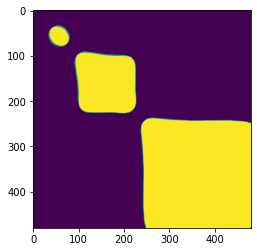

In [3]:
A = np.load("../data/A.npy")
plt.imshow(A)

In [4]:
for _ in range(100):
    mask = random_hole(
        r=np.random.randint(5, 35),
        R=len(A)
    )
    A = A * mask

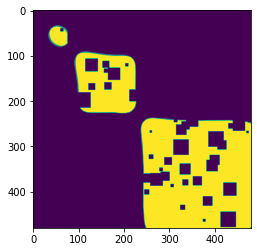

In [5]:
plt.imshow(A)

# Predict

In [6]:
@njit
def convolve_square(A, n=1):
    N, M = A.shape
    assert N == M
    
    result = np.zeros(N)
    shift = n // 2
    
    for i in range(0, N - n):
        
        a = 0
        
        a += A[i, i: i + n].mean()          # top
        a += A[i + n - 1, i: i + n].mean()  # bottom
        a += A[i: i + n, i].mean()          # left          
        a += A[i: i + n, i + n - 1].mean()  # right
        
        result[i + shift] = a / 4
        
    return result


def create_proba(x, n, threshold=0.5):
    
    y = np.convolve(
        x > threshold,
        np.ones(n),
        mode="same"
    )
    
    y = np.clip(y, 0, 1)
    
    return y


def predict_1d(A, **kw):
    
    threshold = kw.get("threshold", 0.75)
    n_min = kw.get("n_min", 11)  # x10 ms
    n_step = kw.get("n_step", 2)
    
    n_max = len(A)
    proba = np.zeros(n_max)

    for n in range(n_min, n_max, n_step):

        x = convolve_square(A, n)
        proba_x = create_proba(x, n, threshold)
        proba = np.vstack([proba, proba_x]).max(axis=0)
        
    return proba

In [7]:
proba = predict_1d(A)

In [8]:
%%timeit
proba = predict_1d(A)

45.4 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


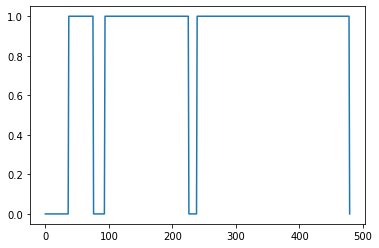

In [9]:
plt.plot(proba)

# Plots

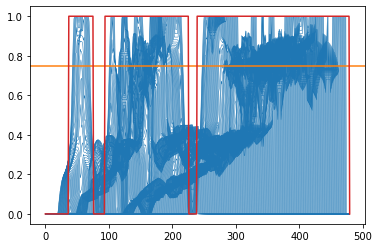

In [10]:
proba = np.zeros(len(A))

threshold = 0.75
i_min = 11  # x10 ms

for i in range(i_min, len(A), 2):
    
    x = convolve_square(A, i)
    plt.plot(x, "-", color="C0", lw=0.5)

    proba_x = create_proba(x, i, threshold)
    proba = np.vstack([proba, proba_x]).max(axis=0)
        
plt.axhline(threshold, color="C1")

plt.plot(proba, color="C3")

In [11]:
starts = np.nonzero(np.diff(proba) > 0)[0]
ends = np.nonzero(np.diff(proba) < 0)[0]

if starts[0] > ends[0]:
    starts = np.hstack([0, starts])

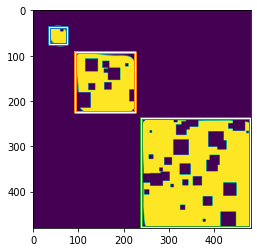

In [12]:
plt.imshow(
    A,
    extent=(0, len(A), len(A), 0)
)

for i, j in zip(starts, ends):
    
    x = [i, i, j, j, i]
    y = [i, j, j, i, i]
        
    plt.plot(
        x,
        y,
        "-",
        lw=3
    )
    
    plt.plot(
        x,
        y,
        "w",
        lw=1
    )